In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.dirname(sys.path[0]))
sys.path.append(PROJECT_ROOT)

import torch
import torch.nn.functional as f
import numpy as np
import tltorch as tlt
import tensorly as ten
from lsr_tensor import *
from lsr_bcd_regression import *
from matplotlib import pyplot as plt
from datasets import synthesize_data
from medmnist import VesselMNIST3D

In [2]:
# Synthetic Dataset
x_stdev = 1
y_stdev = 0.05
sample_size = 2000
val_sample_size = int(sample_size * 0.1)

shapes = (64, 64), (128, 128), (256, 256)
ranks  = (4, 4),   (4, 4),     (4, 4)
separation_ranks = 2, 2, 2

synth_datasets =  []
synth_val_datasets = []

for shape, rank, separation_rank in zip(shapes, ranks, separation_ranks):
    with torch.no_grad():
        true_lsr = LSR_tensor_dot(shape, rank, separation_rank)
        f.normalize(true_lsr.core_tensor, p=2, dim=0, out=true_lsr.core_tensor)
        true_lsr.core_tensor *= (5 / torch.sqrt(torch.sqrt(torch.prod(torch.tensor(ranks)))))
    
        synth_datasets.append(synthesize_data(true_lsr, sample_size, shape, x_stdev, y_stdev))
        synth_val_datasets.append(synthesize_data(true_lsr, val_sample_size, shape, x_stdev, y_stdev))

In [3]:
# Vessel MNIST 3D
vessel_dataset = VesselMNIST3D(split="train", download=True)
vessel_val_dataset = VesselMNIST3D(split="val", download=True)

Using downloaded and verified file: /home/fishcat/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/fishcat/.medmnist/vesselmnist3d.npz


In [4]:
shape, rank, separation_rank = (28, 28, 28), (3, 3, 3), 2
logistic_loss = lambda yp, y: f.nll_loss(torch.sigmoid(yp), y)

print("Starting training...")
init_lsr_dot = LSR_tensor_dot(shape, rank, separation_rank, dtype=torch.double)
_, val_1 = lsr_bcd_regression(logistic_loss, vessel_dataset, init_lsr_dot, lr=0.001, momentum=0.9,\
                              step_epochs=1, max_iter=500, batch_size=None, threshold=1e-4, init_zero=False, ortho=True,\
                              verbose=False, true_param=None, val_dataset=vessel_val_dataset)
print("Finished 1 step GD")

init_lsr_dot = LSR_tensor_dot(shape, rank, separation_rank, dtype=torch.double)
_, val_5 = lsr_bcd_regression(logistic_loss, vessel_dataset, init_lsr_dot, lr=0.001, momentum=0.9,\
                                        step_epochs=5, max_iter=100, batch_size=None, threshold=1e-4, init_zero=False, ortho=True,\
                                        verbose=False, true_param=None, val_dataset=vessel_val_dataset)
print("Finished 5 step GD")

init_lsr_dot = LSR_tensor_dot(shape, rank, separation_rank, dtype=torch.double)
_, val_10 = lsr_bcd_regression(logistic_loss, vessel_dataset, init_lsr_dot, lr=0.001, momentum=0.9,\
                                        step_epochs=10, max_iter=50, batch_size=None, threshold=1e-4, init_zero=False, ortho=True,\
                                        verbose=False, true_param=None, val_dataset=vessel_val_dataset)
print("Finished 10 step GD")

val_losses = [val_1["val_loss"], val_5["val_loss"], val_10["val_loss"]]

Starting training...
Finished 1 step GD
Finished 5 step GD
Finished 10 step GD


NameError: name 'val_losses_per_dataset' is not defined

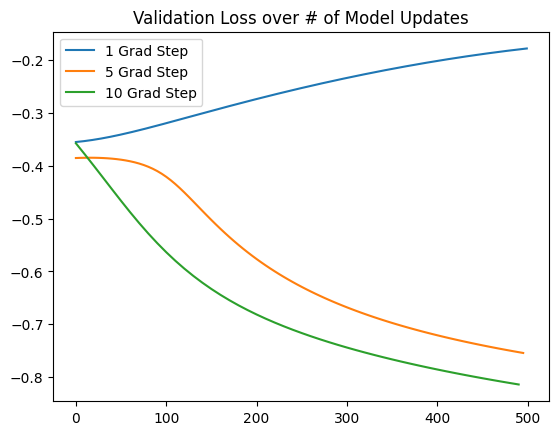

In [11]:
loss1, loss5, loss10 = val_losses
plt.plot(np.arange(len(loss1)), loss1, label="1 Grad Step")
plt.plot(np.arange(len(loss5))*5, loss5, label="5 Grad Step")
plt.plot(np.arange(len(loss10))*10, loss10, label="10 Grad Step")
plt.legend()
plt.title("Validation Loss over # of Model Updates")
plt.show()

In [7]:
val_losses_per_dataset = []

for dataset, val_dataset, shape, rank, separation_rank in zip(synth_datasets, synth_val_datasets, shapes, ranks, separation_ranks):
    print("Starting training...")
    
    init_lsr_dot = LSR_tensor_dot(shape, rank, separation_rank)
    _, val_1 = lsr_bcd_regression(f.mse_loss, dataset, init_lsr_dot, lr=0.001, momentum=0.9,\
                                  step_epochs=1, max_iter=500, batch_size=None, threshold=1e-4, init_zero=False, ortho=True,\
                                  verbose=False, true_param=None, val_dataset=val_dataset)
    print("Finished 1 step GD")
    
    init_lsr_dot = LSR_tensor_dot(shape, rank, separation_rank)
    _, val_5 = lsr_bcd_regression(f.mse_loss, dataset, init_lsr_dot, lr=0.001, momentum=0.9,\
                                            step_epochs=5, max_iter=100, batch_size=None, threshold=1e-4, init_zero=False, ortho=True,\
                                            verbose=False, true_param=None, val_dataset=val_dataset)
    print("Finished 5 step GD")
    
    init_lsr_dot = LSR_tensor_dot(shape, rank, separation_rank)
    _, val_10 = lsr_bcd_regression(f.mse_loss, dataset, init_lsr_dot, lr=0.001, momentum=0.9,\
                                            step_epochs=10, max_iter=50, batch_size=None, threshold=1e-4, init_zero=False, ortho=True,\
                                            verbose=False, true_param=None, val_dataset=val_dataset)
    print("Finished 10 step GD. Switching dataset\n")
    
    val_losses_per_dataset.append([val_1["val_loss"], val_5["val_loss"], val_10["val_loss"]])

Starting training...
Finished 1 step GD
Finished 5 step GD


KeyboardInterrupt: 

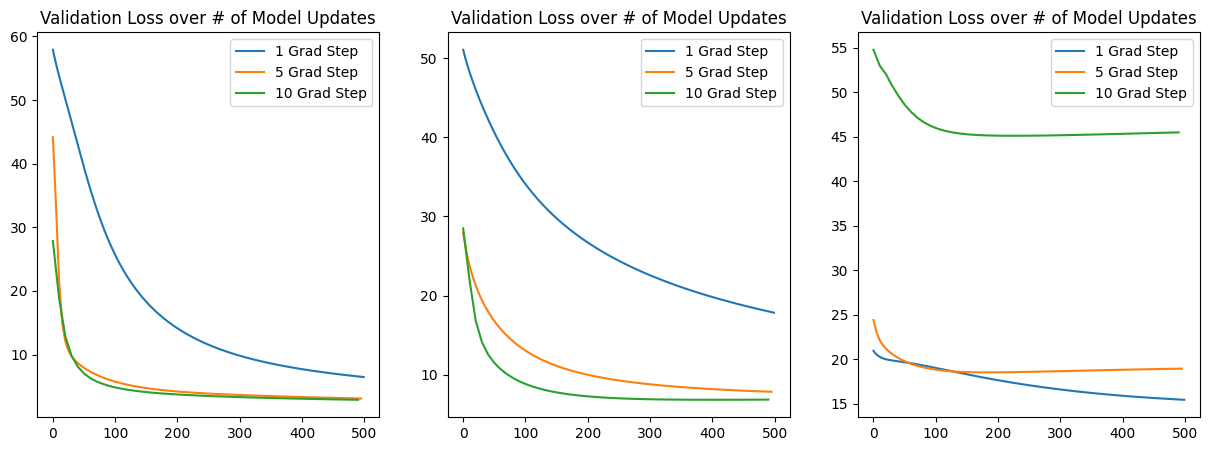

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs.flatten()):
    loss1, loss5, loss10 = val_losses_per_dataset[i]
    ax.plot(np.arange(len(loss1)), loss1, label="1 Grad Step")
    ax.plot(np.arange(len(loss5))*5, loss5, label="5 Grad Step")
    ax.plot(np.arange(len(loss10))*10, loss10, label="10 Grad Step")
    ax.legend()
    ax.set_title("Validation Loss over # of Model Updates")